In [2]:
'''
Unsupervised k-means clustering on standardized and cleaned plain text file versions of EEBO-TCP texts. 

Produces a user-specified number of clusters based on term frequency vectorization. 
These clusters are described using the keywords found in their corresponding entries 
in a metadata CSV file made using metadata.py in Stage I. 

The vectorize and cluster functions are adapted from the EarlyPrint Lab: 
    https://earlyprint.org/jupyterbook/unsupervised.html
The topTerms function is adapted from 
    https://pythonprogramminglanguage.com/kmeans-text-clustering/ 
The elbow and intercluster functions are adapted from Yellowbrick's documentation: 
    https://www.scikit-yb.org/en/latest/index.html
'''
import numpy as np
import pandas as pd
from collections import defaultdict,Counter
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('ggplot')


def vectorize(strings,ids,option):
    '''
    Vectorizes the texts and returns a dataframe of texts mapping to their TCP IDs. 
    '''
    # vector = TfidfVectorizer(min_df=2, sublinear_tf=True)
    # results = vector.fit_transform(strings)
    if option =='count': vector = CountVectorizer()
    else: vector = TfidfVectorizer()
    results = vector.fit_transform(strings)
    return pd.DataFrame(results.toarray(), index=ids, columns=vector.get_feature_names_out()) # Convert information back to a DataFrame

def cluster(df,ids,num):
    model = KMeans(n_clusters=num, random_state=42) 
    model.fit(df) 
    kmeans_groups = defaultdict(list)
    for k,v in zip(model.labels_,ids):
        kmeans_groups[k].append(v)
    return kmeans_groups,model

def topTerms(model,df,num):
    print("Top terms per cluster:")
    centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = list(df.columns)
    for i in range(num):
        top = []
        for ind in centroids[i, :20]:
            top.append(terms[ind])
        print("Cluster %d:" % i,top)

def elbow(df):
    from yellowbrick.cluster.elbow import kelbow_visualizer
    kelbow_visualizer(KMeans(), df, k=(2, 10),timings=False)
    # kelbow_visualizer(KMeans(), df, k=(2, 10),metric='calinski_harabasz',timings=False)
    # kelbow_visualizer(KMeans(), df, k=(2, 10),metric='silhouette',timings=False)
    
def intercluster(model,num):
    from yellowbrick.cluster import intercluster_distance
    intercluster_distance(KMeans(num),model, embedding='mds') 

def pcaColors(kmeans,df):
    '''
    PCA visualization code comes from https://www.askpython.com/python/examples/plot-k-means-clusters-python \n",
    '''
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df) 
    label = kmeans.fit_predict(pca_results) 
    u_labels = np.unique(label)
    groupColors = {0:'pink',1:'purple',2:'darkblue',3:'plum',4:'palevioletred'}
    for i in u_labels:
        plt.scatter(pca_results[label == i , 0] , pca_results[label == i , 1] , label = i,color=groupColors[i])
    plt.legend()
    plt.figure(figsize=(20,10))
    plt.show()

def pca(df):
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df) 
    pca_df = pd.DataFrame(pca_results, columns=["pc1","pc2"])
    pca_df.plot.scatter(x='pc1', y='pc2')
    plt.legend()
    plt.figure(figsize=(20,10))
    plt.show()


In [4]:
import os,re 


def keywords(csv):
    '''
    Returns a dictionary in this format {id : (keywords,date)}
    '''
    df = pd.read_csv(csv)
    keywords = df['keywords']
    ids = df['id']
    dates = df['date']
    numFiles = len(ids)
    count = 0
    dict = {}
    while count < numFiles:
        words = set(keywords[count].split('--'))
        # removing unnecessary keywords
        words.discard('')
        # Removing unnecessary dates  
        newWords = []
        for w in words: 
            w = w.replace('.','')
            w = re.sub(r'\([^)]*\)','',w)
            w = re.sub(r'[."\'-?:!;]', '', w)
            w = re.sub(r' ca|-|[0-9]{4}|,','',w)
            if re.search('Sultan of the Turks',w):
                w = 'Sultan of the Turks'
            if re.search('Süleyman',w):
                w = 'Süleyman'
            w = w.strip()
            newWords.append(w)
        newWords = set(newWords)
        newWords.discard('')
        newWords.discard('-')
        newWords.discard('th century')
        newWords.discard('I')
        newWords.discard('Early works to')
        newWords.discard('To')
        newWords.discard('No Keywords')
        newWords.discard('Great Britain')
        dict[ids[count]] = (newWords,dates[count])
        count += 1
    return dict 
    
def getTexts(folder,searchList):
    fileToText = {}
    underscores = {}
    for root,dirs,files in os.walk(folder):
        for file in files:
                if '.txt' not in file: continue
                path = os.path.join(folder,file)
                f = open(path,'r')
                text = f.readlines()[0]
                if '_' in file: 
                        name = file.split('_')[0]
                        if name not in searchList: continue
                        if name not in underscores.keys(): 
                                underscores[name] = text
                        else: underscores[name] = underscores[name] + ' ' + text
                else: 
                        name = file.split('.')[0]
                        if name not in searchList: continue
                        fileToText[name] = text
                f.close()
        for name,text in underscores.items():
            fileToText[name] = text
        return fileToText

In [5]:
'''Get Topic Words for each text in a dictionary'''
readFile = open('/srv/data/periodFeatures/period4features/period1625topics.txt','r')
topics = {}
for line in readFile:
    tcpID =  line.split(':')[0].strip('.txt')
    topic = line.split(':')[1].strip()
    topic = re.sub(r' if | of | by | yet | the | man | see | and ',' ',topic)
    topic = re.sub('  ',' ',topic)
    topics[tcpID] = topic.split(' ')
readFile.close()
print(len(topics))

1351


In [6]:
'''Get additional features'''
inFile = open('/srv/data/periodFeatures/period4features/featuresPeriod1625.txt','r')
inFileLines = inFile.readlines()
inFile.close()
featuresDict = {}
for line in inFileLines: 
    line = line.split(':')
    features = line[1].strip().split(' ')
    featuresDict[line[0].strip()] = features
print(len(featuresDict))

'''Get drug and tobacco features'''
tobacco = 'tobacco|tobaco|tobacca|tobacconist'
drug = 'drug|drugge|drugg|elixir|apothecary|confection|confect|medicinable|medicine|medecine|medicament|arsenic|poppy|chemic|medicinal|intoxicate|tacamahaca|potion|mithridate|antimony|opiate|opium'

inFile = open('/srv/data/periodFeatures/period4features/drugTobaccoPeriod1625.txt','r')
inFileLines = inFile.readlines()
inFile.close()
tobaccoDrug = {}
for line in inFileLines: 
    line = line.split(':')
    features = line[1].strip().split(' ')
    if features[0] == '': continue
    
    '''For specifically tobacco texts'''
    instances = re.findall(tobacco,' '.join(features))
    if len(instances) < 1: continue
    tobaccoDrug[line[0].strip()] = features
print(len(tobaccoDrug))

'''Get tobacco n-gram features'''
inFile = open('/srv/data/periodFeatures/period4features/newtobaccograms.txt','r')
inFileLines = inFile.readlines()
inFile.close()
tobaccoNgrams = {}
for line in inFileLines: 
    line = line.split(':')
    features = line[1].strip()
    if features == '': continue
    tobaccoNgrams[line[0].strip()] = features.strip()
print(len(tobaccoNgrams))

1351
105
81


In [7]:
'''Get keywords metadata for each text in a dictionary'''
'''Create list of feature strings for each file and remove stopwords'''
import re 
from timePeriods import period4
features = {}
textInfo = getTexts('/srv/data/relevantEPBodySTOP',period4)
kwdict = keywords('/srv/data/metadata/tuning/relevant.csv')

for ID in tobaccoNgrams.keys():
    '''Skip the texts that do not have any mention of tobacco or drugs'''
    features[ID] = [textInfo[ID]]
    kWords = (list(kwdict[ID][0]))
    features[ID].append(' '.join(kWords*50))
    features[ID].append(' '.join(topics[ID]*50))
    features[ID].append(' '.join(featuresDict[ID]*20))
    features[ID].append(' '.join(tobaccoDrug[ID]*20))
    features[ID].append(' '.join(tobaccoNgrams[ID]*10))
    featureStr = ' '.join(features[ID])
    featureStr = re.sub(r' if | of | by | yet | the | man | see | and ',' ',featureStr)
    featureStr = re.sub('  ',' ',featureStr)
    features[ID] = featureStr
print(f'Total number of texts to classify is {len(features)}')

Total number of texts to classify is 81


In [22]:
print(list(features.keys()))

['B12280', 'A01055', 'A20065', 'A10187', 'A20356', 'A69225', 'A22447', 'A22574', 'A11151', 'A12155', 'A02758', 'A13520', 'A15685', 'A06902', 'A16507', 'A16627', 'A08977', 'A19012', 'A03411', 'A03559', 'A13948', 'A07024', 'A19036', 'A04633', 'B00490', 'A72399', 'A72911', 'A68252', 'A20075', 'A01425', 'A22435', 'A22537', 'A22567', 'A68568', 'A11626', 'A02325', 'A02827', 'A02836', 'A03065', 'A12471', 'A03807', 'A13415', 'A13436', 'A14301', 'A05320', 'A14916', 'A05657', 'A15627', 'A16489', 'A09156', 'A00583', 'A11156', 'A06692', 'A07025', 'A09010', 'A09242', 'A19765', 'B01146', 'A72254', 'A20769', 'A10402', 'A01552', 'A21075', 'A22439', 'A22571', 'A11153', 'A02909', 'A12458', 'A12481', 'A03240', 'A13534', 'A04658', 'A14305', 'A06768', 'A16924', 'A08017', 'A17595', 'A09118', 'A01424', 'A08578', 'A08690']


In [ ]:
df = vectorize(features.values(),features.keys(),'tfidf')
# pca(df)
# elbow(df)

Top terms per cluster:
Cluster 0: ['christian', 'ship', 'pleasure', 'god', 'profit', 'company', 'cloth', 'england', 'money', 'cape', 'sin', 'christ', 'good', 'law', 'adventure', 'arab', 'french', 'lord', 'france', 'greed']
Cluster 1: ['tobacco', 'plantation', 'monopolies', 'import', 'islands', 'virginia', 'colonies', 'bermuda', 'legislation', 'retail', 'colony', 'england', 'industry', 'commerce', 'charles', 'history', 'pleasure', 'majesty', 'importation', 'spanish']
Cluster 2: ['ship', 'money', 'company', 'business', 'cloth', 'tobacco', 'trade', 'pleasure', 'england', 'spain', 'french', 'good', 'france', 'christian', 'cape', 'spaniard', 'love', 'merchant', 'stock', 'out']
Cluster 3: ['sugar', 'medicine', 'tobacco', 'cloth', 'water', 'company', 'profit', 'copper', 'india', 'use', 'pleasure', 'mithridate', 'arab', 'ship', 'take', 'muhammad', 'good', 'medicinable', 'body', 'wine']
Cluster 4: ['plantation', 'england', 'ship', 'india', 'virginia', 'adventure', 'french', 'colony', 'company',

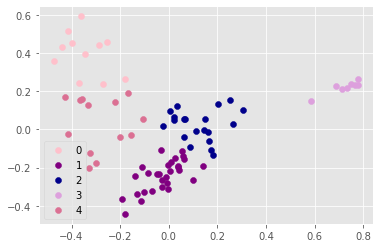

<Figure size 1440x720 with 0 Axes>

In [45]:
k=5
groups,model = cluster(df,features.keys(),k)
topTerms(model,df,k)
pcaColors(model,df)

In [13]:
'''Clustering results for tobacco Period 4'''

Group0 = ['B12280', 'A10187', 'A03411', 'A19036', 'A68568', 'A11626', 'A14301', 'A14916', 'A15627', 'A09156', 'A00583', 'A19765', 'A20769', 'A12481', 'A13534', 'A14305', 'A08017', 'A09118', 'A08578']
Group2 = ['A01055', 'A20065', 'A20356', 'A69225', 'A11151', 'A12155', 'A13520', 'A08977', 'A19012', 'A03559', 'A13948', 'A07024', 'A04633', 'B00490', 'A72399', 'A68252', 'A20075', 'A02827', 'A02836', 'A03807', 'A13415', 'A13436', 'A05320', 'A16489', 'A06692', 'A07025', 'A09242', 'B01146', 'A72254', 'A10402', 'A21075', 'A11153', 'A02909', 'A03240', 'A04658', 'A16924', 'A08690']
Group1 = ['A22447', 'A22574', 'A22435', 'A22537', 'A22567', 'A22439', 'A22571']
Group3 = ['A02758', 'A06902', 'A16627', 'A01425', 'A03065', 'A05657', 'A11156', 'A01552', 'A06768', 'A01424']
Group4 = ['A15685', 'A16507', 'A72911', 'A02325', 'A12471', 'A09010', 'A12458', 'A17595']
groups = {0:Group0,1:Group1,2:Group2,3:Group3,4:Group4}

'''Write out documentation k-means clustering'''

outfile = open('/srv/data/amy/per4doc.txt','a+')
for k in groups.keys():
    kWords = []
    tWords = []
    outfile.write(f'Cluster {k}:')
    for TCPID in groups[k]:
        kWords.extend(list(kwdict[TCPID][0]))
        tWords.extend(topics[TCPID])
    outfile.write(f'<br><ul><li><b>TCP IDs:</b> {groups[k]}</li>')
    outfile.write(f'<li><b>Keywords:</b> {Counter(kWords).most_common(n=10)}</li>')
    outfile.write(f'<li><b>Topic words:</b> {Counter(tWords).most_common(n=10)}</li></ul>')
outfile.write('\n\n\n')

3

In [147]:
meta = pd.read_csv('/srv/data/metadata/tuning/relevant.csv')
authorDict = {}
for idx,tcpID in enumerate(meta['id']):
    if tcpID in features.keys(): 
        authorDict[tcpID] = []
        words = set(meta['author'][idx].split(';'))
        words.discard('')
        newWords = []
        for w in words: 
            w = w.strip()
            if re.search('printer|engraver',w):continue
            newWords.append(w)
        authorDict[tcpID] = list(set(newWords))
for TCPID,authorList in authorDict.items(): 
    for author in authorList: 
        if author == 'James, Thomas, 1593?-1635?' : 
            print(author,': ', TCPID,': ',tobaccoNgrams[TCPID]) 
        # if author == 'Jonson, Ben, 1573?-1637, attributed name.':
        #     print(author,': ', TCPID,': ',tobaccoNgrams[TCPID])
        

Jonson, Ben, 1573?-1637. :  A04658 :  tobacco_and_pipe
Jonson, Ben, 1573?-1637. :  A04633 :  tobacco_pipe tobacco_there pipe_of_tobacco ale_and_tobacco weed_tobacco tobacco_taker tobacco_out tobacco_when tobacco_for_which that_tobacco smoke_of_tobacco good_tobacco
Jonson, Ben, 1573?-1637, attributed name. :  A20356 :  tobacco_take
